In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split, Dataset
from torchvision import models
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from glob import glob
import cv2
import sys
!pip install timm
import timm
import tqdm
from torchvision import datasets
import random
import math
from PIL import Image                                 
import torchvision.transforms.functional as TF        
from timm.models.layers import to_2tuple
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.8 MB/s eta 0:00:00


In [2]:
# # If have more than 1 GPU and need to specify which GPU to use

# torch.cuda.set_device(0)
# print('__Python VERSION:', sys.version)
# print('__pyTorch VERSION:', torch.__version__)
# print('__CUDA VERSION')
# from subprocess import call
# # call(["nvcc", "--version"]) does not work
# ! nvcc --version
# print('__CUDNN VERSION:', torch.backends.cudnn.version())
# print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
# print('Active CUDA Device: GPU', torch.cuda.current_device())
# print ('Available devices ', torch.cuda.device_count())
# print ('Current cuda device ', torch.cuda.current_device())

Define custom dataset

In [3]:
#Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Find the mean and std of each dataset (for later normalization purpose)

In [4]:

first_transform = T.Compose([
      T.Resize((224, 224)),
      T.ToTensor(),
  ])


In [5]:
# import torchvision.datasets.ImageFolder
# IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_1donor/'
# IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_2donor/'
IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_bbox/'

root_tr = IMG_PATH + 'train/'
root_val = IMG_PATH + 'val/'
root_test = IMG_PATH + 'test/'

In [6]:
class patch_dataset(Dataset):
    def __init__(self, root_dir, transform):

        # self
        self.root_dir = root_dir
        self.path_hc = glob(os.path.join(self.root_dir+ '/0/*.jpg'))
        self.path_lk = glob(os.path.join(self.root_dir+ '/1/*.jpg'))
        self.img_path_list = self.path_hc + self.path_lk
        self.transform = transform
        self.identity = np.array(range(len(self.img_path_list)), dtype=str)

    def __getitem__(self, idx:int):

        img_name = self.img_path_list[idx]
        current_name = img_name.split('/')[-1]
        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.transpose(img, (2, 0, 1))
        
        if self.transform is not None:
          img = self.transform(img)

        if current_name.split('_')[0][0] == 'H':
          label = 0
        else:
          label = 1
        sample = {'image': img, 'label':torch.tensor(label, dtype=torch.int8), 'idx': idx }
        
        return sample 

    def __len__(self):
        return len(self.img_path_list)

In [7]:
train_dataset = torchvision.datasets.ImageFolder(root = root_tr, transform = first_transform)
valid_dataset = torchvision.datasets.ImageFolder(root = root_val, transform = first_transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=len(valid_dataset), num_workers=2)
test_dataset = torchvision.datasets.ImageFolder(root = root_test, transform = first_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), num_workers =2)

In [8]:
# for i in range(len(trainloader)):

#   data = next(iter(trainloader))
  
#   print((data[0]).shape)

#   R = torch.mean(data[0]), torch.std(data[0])

#   break
# print(R)

In [9]:
# for i in range(len(validloader)):
#   data = next(iter(validloader))
#   print((data[0]).shape)
#   bb = data[0].mean(), data[0].std()
#   break
# print(bb)

In [10]:
# for i in range(len(testloader)):
#   data = next(iter(testloader))
#   print((data[0]).shape)
#   bb = data[0].mean(), data[0].std()
#   break
# print(bb)

Now define the train/val/test transform with pre-calculated mean and std in each dataset

In [11]:
test_transform = T.Compose([
      T.ToPILImage(), 
      T.ToTensor(),
      T.Normalize(0.0546, 0.1130),
  ])

val_transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor(),
      T.Normalize(0.0563, 0.1224),
  ])

train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),  
    T.ToTensor(),
    T.Normalize(0.0452, 0.1023),
])

In [12]:
try_dataset = patch_dataset(root_val, val_transform)

(224, 224, 3)
(224, 224, 3)
label tensor(0, dtype=torch.int8)
identity 100


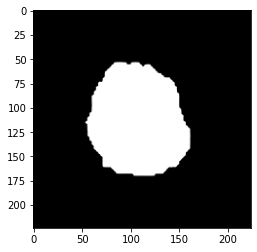

In [13]:
batch = try_dataset.__getitem__(100)
img = batch['image'].numpy()
img = img
img = np.transpose(img, (1,2,0))
print(img.shape)
label = batch['label']
print(img.shape)
plt.imshow(img)
print('label',label)
print('identity', batch['idx'])

In [14]:
# print(train_filenames[100])

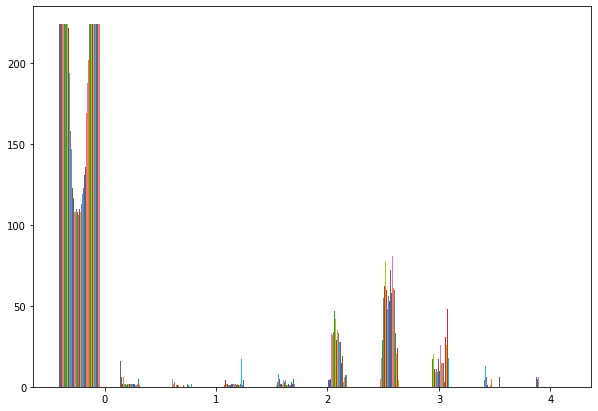

In [15]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(img[:,:,0])
 
# Show plot
# fig, ax = plt.subplots(figsize =(10, 7))
# ax.hist(img[:,:,1])
plt.show()

In [16]:
def number_of_imgs(path):
  
  class_num = []
  for value in os.listdir(path):
    total_num = 0
    print(value, "has", len(os.listdir(path + value)), "imgs")
    total_num = total_num + len(os.listdir(path + value))
    class_num.append(total_num)
  print('\n')
  return sum(class_num)
    
    

ratio = number_of_imgs(root_tr)

print(ratio)
# print(val_num)

1 has 300 imgs
0 has 300 imgs


600


In [17]:

HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 1
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

# If you would like to play around with the partially freeze model, note: the defualt setting is free
# for param in model.parameters(): #freeze model
#     param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()    
)
print(model.head)
model = model.to(device)


Using cache found in /root/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=1, bias=True)
  (4): Sigmoid()
)


In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)
num_epochs = 40

In [25]:
# change the path according to your path
# IMG_PATH = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/all_dataset/'
# IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_1donor/'
# IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_2donor/'
IMG_PATH = '/content/drive/MyDrive/DL-T Cell Segmentatiom/tr_val_test_bbox/'
# root_tr = IMG_PATH +'train/'
# root_val = IMG_PATH + 'val/'
root_tr = IMG_PATH +'val/'
root_val = IMG_PATH + 'train/'
root_test = IMG_PATH + 'test/'
bs = 32

train_dataset = patch_dataset(root_dir = root_tr, transform = train_transform)
valid_dataset = patch_dataset(root_dir = root_val, transform = test_transform)
test_dataset = patch_dataset(root_dir = root_test, transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, num_workers=2, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, num_workers=2, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, num_workers=2, shuffle = True)

train_filenames = glob(os.path.join(root_tr + '/0/*.jpg')) + glob(os.path.join(root_tr + '/1/*.jpg'))
valid_filenames = glob(os.path.join(root_val + '/0/*.jpg')) + glob(os.path.join(root_val + '/1/*.jpg'))
test_filenames = glob(os.path.join(root_test + '/0/*.jpg')) + glob(os.path.join(root_test + '/1/*.jpg'))


In [26]:


# Define the K-fold Cross Validator
kfold = 1
train_acc = []
train_result = []
valid_acc = []
valid_result = []
bs =bs


patience = 2


def train_net(patience, number_id):
    
    trigger_times = 0
    
    # Start print
    print('--------------------------------')

   
    print('--------------------------------')

#       IMG_PATH = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/CV' + str(number_id) + '_multiplied/'


    n_train = len(trainloader)
    n_valid = len(validloader)    

    train_accuracy = list()
    train_loss = list()
    valid_loss = list()
    valid_accuracy = list()

    loss_function = nn.BCELoss().to(device)


    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')
        model.train()
        train_batch_loss = list()
        train_batch_accuracy = list()
        
        # Iterate over the DataLoader for training data
        for i, batch in enumerate(trainloader):
                train_correct = 0
                train_total = 0

                inputs = batch['image'].to(device)
                labels = batch['label'].float().view(inputs.size(0), 1).to(device)

                outputs = model(inputs)

                pred_binary = (outputs > 0.5)

                # Compute loss
                loss = loss_function(outputs, labels)

                train_correct = train_correct + (pred_binary == labels).sum().item()
                train_total = train_total + labels.size(0)

                # Zero the gradients
                optimizer.zero_grad()

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()
                # exp_lr_scheduler.step()

              # Print statistics
                batch_loss = loss.item()
                train_batch_loss.append(batch_loss)
                train_batch_accuracy.append(train_correct/train_total)

        epoch_train_loss = np.array(train_batch_loss).mean()
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = np.array(train_batch_accuracy).mean()
        train_accuracy.append(epoch_train_accuracy)

        model.eval()
        valid_batch_loss = list()
        valid_batch_accuracy = list()
        
        with torch.set_grad_enabled(False):

            # Iterate over the test data and generate predictions
                for i, batch in enumerate(validloader):
                    valid_correct = 0
                    valid_total = 0

                    inputs = batch['image'].to(device)
                    labels = batch['label'].float().view(inputs.size(0),1).to(device)


                    outputs = model(inputs)

                    pred_binary = (outputs > 0.5)

                    loss = loss_function(outputs, labels)
                    # print('loss', loss)
                    valid_correct = valid_correct + (pred_binary == labels).sum().item()
                    valid_total = valid_total + labels.size(0)

                    batch_loss = loss.item()
                    valid_batch_loss.append(batch_loss)

                    valid_batch_accuracy.append(valid_correct/valid_total)



                epoch_valid_loss = np.array(valid_batch_loss).mean()
                valid_loss.append(epoch_valid_loss)
                epoch_valid_accuracy = np.array(valid_batch_accuracy).mean()
                valid_accuracy.append(epoch_valid_accuracy)

        print(f'EPOCH {epoch + 1}/{num_epochs} - Training Loss: {epoch_train_loss} - Training Accuracy: {epoch_train_accuracy} - Validation Loss: {epoch_valid_loss} - Validation Accuracy: {epoch_valid_accuracy}')  
        # torch.save(model.state_dict(), f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model/epoch_{epoch+1:03}.pth')
        # torch.save(model.state_dict(), f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model_28th/epoch_{epoch+1:03}.pth')
        torch.save(model.state_dict(), f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model_bbox/epoch_{epoch+1:03}.pth')
#         if epoch > 3:
#             if valid_accuracy[-1] - valid_accuracy[-2] > 0:
#                 trigger_times += 1
#             print('Trigger Times:', trigger_times)

#         if trigger_times >= patience:
#             print('Early stopping!\nStart to test process.')
#             break


    print('--------------------------------')

    return train_loss, train_accuracy, valid_loss, valid_accuracy, train_filenames, valid_filenames

In [27]:
number_id = 2
avg_train_loss, avg_train_accuracy, avg_valid_loss, avg_valid_accuracy, train_filenames, valid_filenames = train_net(3, number_id)

--------------------------------
--------------------------------
Starting epoch 1
EPOCH 1/40 - Training Loss: 0.6931992965809842 - Training Accuracy: 0.5182845744680851 - Validation Loss: 0.6937260967493057 - Validation Accuracy: 0.5153125
Starting epoch 2
EPOCH 2/40 - Training Loss: 0.6901319134742656 - Training Accuracy: 0.5251551418439716 - Validation Loss: 0.6851551932096481 - Validation Accuracy: 0.5890625
Starting epoch 3
EPOCH 3/40 - Training Loss: 0.6862027404156137 - Training Accuracy: 0.5561835106382979 - Validation Loss: 0.6834774577617645 - Validation Accuracy: 0.580625
Starting epoch 4
EPOCH 4/40 - Training Loss: 0.6803429602308476 - Training Accuracy: 0.5841090425531915 - Validation Loss: 0.6795655739307404 - Validation Accuracy: 0.5946875
Starting epoch 5
EPOCH 5/40 - Training Loss: 0.6723957550018391 - Training Accuracy: 0.6163563829787234 - Validation Loss: 0.6741853243112564 - Validation Accuracy: 0.6159375
Starting epoch 6
EPOCH 6/40 - Training Loss: 0.6543909114726

11


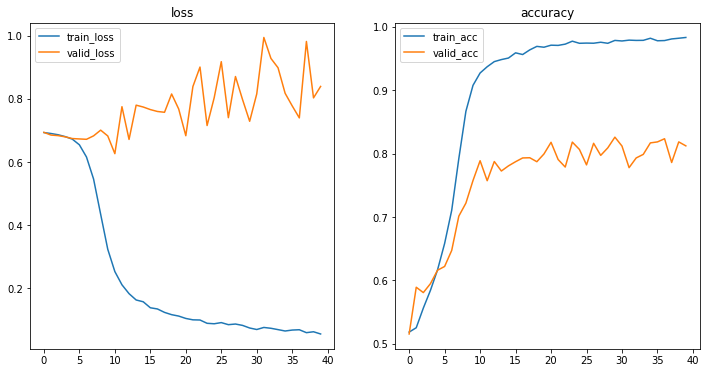

In [28]:
best_epoch = (np.argmin(avg_valid_accuracy) + 1)
# best_epoch = (np.argmax(avg_valid_accuracy) + 1)
print(best_epoch)
plt.figure(figsize = [12, 6])
plt.subplot(121)
plt.plot(avg_train_loss, label="train_loss")
plt.plot(avg_valid_loss, label="valid_loss")
plt.title('loss')
plt.legend()

plt.subplot(122)
plt.plot(avg_train_accuracy, label="train_acc")
plt.plot(avg_valid_accuracy, label="valid_acc")
plt.title('accuracy')
plt.legend()

In [29]:
best_epoch = 8
# state_dict = torch.load(f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model/epoch_{best_epoch:03}.pth')
# state_dict = torch.load(f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model_28th/epoch_{best_epoch:03}.pth')
# state_dict = torch.load(f'/content/drive/MyDrive/Jan11th/residual_attention_unet/epoch_{best_epoch:03}.pth')
state_dict = torch.load(f'/content/drive/MyDrive/DL-T Cell Segmentatiom/saved_model_bbox/epoch_{best_epoch:03}.pth')

model.load_state_dict(state_dict)
model.cuda()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
def plot_roc_curve(true_y, y_prob):
      fpr, tpr, thresholds = roc_curve(true_y, y_prob)
      plt.figure()
      plt.plot(fpr, tpr)
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')


In [31]:
import re
def image_accuracy(result, ratio, type):

    idx = result[:,2]
    pred = result[:,1]
    image_list = list()

    if type == 'train':
        filenames = train_filenames
    elif type == 'val':
        filenames = valid_filenames
    elif type == 'test':
        filenames = test_filenames

    for i in (idx):
        i = int(i)
        curr_identity = filenames[i].split('/')[-1]
        image_name = re.sub(curr_identity.split('_')[-1], '', curr_identity)
        image_list.append(image_name) 

    image_list = np.asarray(image_list)
    num_imgs = len(np.unique(image_list))
    true_label = 0
    pred_label = 0
    image_pred_label = np.zeros((num_imgs))
    image_true_label = np.zeros((num_imgs))
    image_pred_rate = np.zeros((num_imgs))
    
    for i in range(num_imgs):
        current_image_name = np.unique(image_list)[i] 
        patch_id = np.where(image_list == current_image_name)
        patch_id = np.array(patch_id)
        positive_ratio = np.sum(pred[patch_id] == 1)/patch_id.shape[1]
        image_pred_rate[i] = positive_ratio

        if positive_ratio > ratio:
            pred_label = 1
        else:
            pred_label = 0
        
        print(current_image_name, positive_ratio)
        if current_image_name[0] == 'L':
            true_label = 1
        else:
            true_label = 0
            
        image_true_label[i] = true_label
        image_pred_label[i] = pred_label
        
    print('img', image_pred_label)
    print('labels', image_true_label)
    print(np.sum(image_pred_label == image_true_label))
    accuracy = np.sum(image_true_label == image_pred_label)/len(np.unique(image_list))
 
    return accuracy, image_pred_label, image_true_label, image_pred_rate

In [32]:
def test_net(net, test_dataloader, ratio, num, data_type ):
    
    net.eval()
    n_test = len(test_dataloader)
    # test_batch_loss = list()
    # test_batch_dice = list()
    batch_test_accuracy = list()
    # test_batch_CM = list()
    batch_test_loss = list()
    result = np.zeros((num, 4))

    loss_function = nn.BCELoss().to(device)

    # This part is almost the same as the validation loop in `train_net` function. 
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            
            
            # Load a batch and pass it to the GPU
            test_correct = 0
            imgs = batch['image'].to(device)
            # print('image',imgs.shape)
            # print('labels',batch['label'].shape )
            labels = batch['label'].float().view(imgs.size(0),1).to(device)
            idx = batch['idx'].int().view(imgs.size(0),1).to(device)
 
            y_pred = net(imgs)
            pred_binary = (y_pred > 0.5).to(device)
            # pred_binary = y_pred.cpu().numpy()

            loss = loss_function(y_pred, labels).item()
            batch_test_loss.append(loss)

            test_correct = test_correct + (pred_binary == labels).sum().item()
            test_total = labels.size(0)
            batch_test_accuracy.append(test_correct/test_total)

            batch_result = np.concatenate((labels.cpu().numpy(), pred_binary.cpu().numpy(),idx.cpu().numpy(), y_pred.cpu()), axis=1)
            bs_num = bs
            if i == len(test_dataloader)-1:
                result[(i)*bs_num:,:] = batch_result
            else:     
                result[(i)*bs_num:(i)*bs_num + bs_num,:] = batch_result

        test_loss = np.array(batch_test_loss).mean()
        test_accuracy = np.array(batch_test_accuracy).mean()

        
        dir_type = data_type
        test_img_accuracy, img_pred, img_true, img_pred_rate = image_accuracy(result, ratio, dir_type)


        print(f'Test Loss: {test_loss} - Patch Level Accuracy: {test_accuracy} - Image Level Accuracy: {test_img_accuracy}')              
    
    return result, img_pred, img_true, img_pred_rate

In [33]:
number_id = 2
# # bs = 256
# IMG_PATH = '/media/sail/HDD14T/BME_Grad_Project/Xin and Shiqi/CV' + str(number_id) + '_multiplied/'
# root_val = IMG_PATH + 'test/'
test_dataset = patch_dataset(root_dir = root_test, transform = test_transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0, shuffle=True)

# testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, num_workers=0)

In [34]:
num_imgs = number_of_imgs(root_test)
print(num_imgs)

1 has 643 imgs
0 has 346 imgs


989


In [35]:
pat_result_test, img_pred_test, img_true_test, img_pred_rate_test = test_net(model, testloader, ratio = 0.5, num=number_of_imgs(root_test), data_type = 'test')

1 has 643 imgs
0 has 346 imgs


H1_20210225_10to1_40min_2_01_ 0.0
H1_20210225_10to1_40min_2_02_ 0.03333333333333333
H1_20210225_10to1_40min_2_03_ 0.06666666666666667
H1_20210225_10to1_40min_2_04_ 0.07142857142857142
H1_20210225_10to1_40min_2_05_ 0.0
H1_20210225_3to1_40min_2_01_ 0.17647058823529413
H1_20210225_3to1_40min_2_02_ 0.12195121951219512
H1_20210225_3to1_40min_2_03_ 0.025
H1_20210225_3to1_40min_2_04_ 0.02857142857142857
H1_20210225_3to1_40min_2_05_ 0.02702702702702703
LK63_20210319_1to3_40min_2_01_ 0.4418604651162791
LK63_20210319_1to3_40min_2_02_ 0.4883720930232558
LK63_20210319_1to3_40min_2_03_ 0.6206896551724138
LK63_20210319_1to3_40min_2_04_ 0.631578947368421
LK63_20210319_1to3_40min_2_05_ 0.575
LK63_20210319_1to3_40min_2_06_ 0.6285714285714286
LK63_20210319_1to3_40min_2_07_ 0.6111111111111112
LK63_20210319_1to3_40min_2_08_ 0.7674418604651163
LK63_20210319_1to3_40min_2_09_ 0.41025641025641024
LK63_20210319_1to3_40min_2_10_ 0.4838709677419355
LK75_20210722_10to1_2_01_ 0.8571

In [36]:
val_dataset = patch_dataset(root_dir = root_val, transform = test_transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, num_workers=0)

In [ ]:
print(bs)

In [37]:
num_imgs = number_of_imgs(root_val)
print(num_imgs)
# print(len(trloader))

1 has 1600 imgs
0 has 1600 imgs


3200


In [38]:
pat_result_val, img_pred_val, img_true_val, img_pred_rate_val = test_net(model, valloader, ratio = 0.5, num=number_of_imgs(root_val),  data_type = 'val')

1 has 1600 imgs
0 has 1600 imgs


H3_20210917_10to1_40min_2_01_ 0.058823529411764705
H3_20210917_10to1_40min_2_02_ 0.0
H3_20210917_10to1_40min_2_03_ 0.07142857142857142
H3_20210917_10to1_40min_2_04_ 0.0
H3_20210917_10to1_40min_2_05_ 0.0
H3_20210917_10to1_40min_2_06_ 0.21428571428571427
H3_20210917_10to1_40min_2_07_ 0.08695652173913043
H3_20210917_10to1_40min_2_08_ 0.12
H3_20210917_10to1_40min_2_09_ 0.0
H3_20210917_10to1_40min_2_10_ 0.0
H3_20210917_1to3_40min_2_01_ 0.35
H3_20210917_1to3_40min_2_02_ 0.6176470588235294
H3_20210917_1to3_40min_2_03_ 0.5384615384615384
H3_20210917_1to3_40min_2_04_ 0.5517241379310345
H3_20210917_1to3_40min_2_05_ 0.5217391304347826
H3_20210917_1to3_40min_2_06_ 0.5357142857142857
H3_20210917_1to3_40min_2_07_ 0.6
H3_20210917_1to3_40min_2_08_ 0.43478260869565216
H3_20210917_1to3_40min_2_09_ 0.28
H3_20210917_1to3_40min_2_10_ 0.36363636363636365
H3_20210917_3to1_40min_2_01_ 0.125
H3_20210917_3to1_40min_2_02_ 0.19047619047619047
H3_20210917_3to1_40min_2_03_ 0.1
H3_2

In [39]:
tr_dataset = patch_dataset(root_dir = root_tr, transform = test_transform)
trloader = torch.utils.data.DataLoader(tr_dataset, batch_size=bs, num_workers=0)

In [40]:
pat_result_tr, img_pred_tr, img_true_tr, img_pred_rate_tr = test_net(model, trloader, ratio = 0.5, num=number_of_imgs(root_tr),  data_type = 'train')

1 has 1500 imgs
0 has 1500 imgs


H2_20210401_10to1_40min_2_01_ 0.28
H2_20210401_10to1_40min_2_02_ 0.0
H2_20210401_10to1_40min_2_03_ 0.034482758620689655
H2_20210401_10to1_40min_2_04_ 0.0
H2_20210401_10to1_40min_2_05_ 0.0
H2_20210401_10to1_40min_2_06_ 0.0
H2_20210401_10to1_40min_2_07_ 0.0
H2_20210401_10to1_40min_2_08_ 0.06666666666666667
H2_20210401_10to1_40min_2_09_ 0.0
H2_20210401_10to1_40min_2_10_ 0.037037037037037035
H2_20210401_1to3_40min_2_01_ 0.0
H2_20210401_1to3_40min_2_02_ 0.0
H2_20210401_1to3_40min_2_03_ 0.0
H2_20210401_1to3_40min_2_04_ 0.0
H2_20210401_1to3_40min_2_05_ 0.0
H2_20210401_1to3_40min_2_06_ 0.0
H2_20210401_1to3_40min_2_07_ 0.0
H2_20210401_1to3_40min_2_08_ 0.02857142857142857
H2_20210401_1to3_40min_2_09_ 0.0
H2_20210401_1to3_40min_2_10_ 0.0625
H2_20210401_3to1_2_01_ 0.0625
H2_20210401_3to1_2_02_ 0.0
H2_20210401_3to1_2_03_ 0.0
H2_20210401_3to1_2_04_ 0.0
H2_20210401_3to1_2_05_ 0.0
H2_20210401_3to1_2_06_ 0.0
H2_20210401_3to1_2_07_ 0.025
H2_20210401_3to1_2_08_ 0.0
H2_20

In [41]:
pat_pred_tr = pat_result_tr[:,3]
pat_true_tr = pat_result_tr[:,0]
print(pat_pred_tr.shape)

(3000,)


In [42]:
pat_pred_val = pat_result_val[:,3]
pat_true_val = pat_result_val[:,0]
print(pat_pred_val.shape)

(3200,)


In [43]:
pat_pred_test = pat_result_test[:,3]
pat_true_test = pat_result_test[:,0]
print(pat_pred_test.shape)

(989,)


In [44]:
def ROCanalysis(pred, true):
    
    fpr, tpr, thresholds = roc_curve(true, pred)
#     print(fpr[:10],tpr[:10],thresholds[:10])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label="AUC="+str(roc_auc_score(true, pred)))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    print("Area under the ROC cuve : %f" % roc_auc)
          
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' :pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(thresholds, index = i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
#     print(roc_t)
#     print(roc_t['threshold'])
    
    print("Optimal cutoff point is : %f" % roc_t['threshold'])
    
          

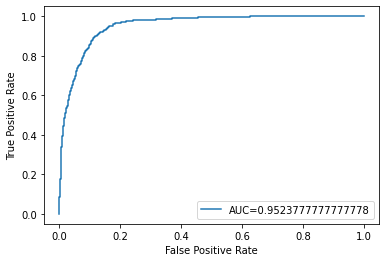

Area under the ROC cuve : 0.952378
Optimal cutoff point is : 0.542092


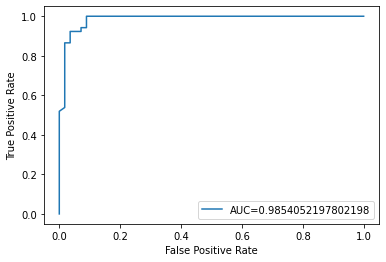

Area under the ROC cuve : 0.985405
Optimal cutoff point is : 0.852941


In [45]:
ROCanalysis(pat_pred_tr, pat_true_tr)
ROCanalysis(img_pred_rate_tr, img_true_tr)

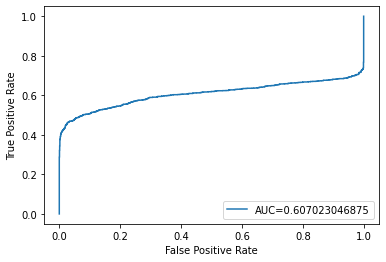

Area under the ROC cuve : 0.607023
Optimal cutoff point is : 0.367432


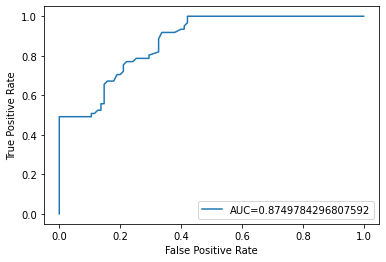

Area under the ROC cuve : 0.874978
Optimal cutoff point is : 0.105263


In [46]:
ROCanalysis(pat_pred_val, pat_true_val)
ROCanalysis(img_pred_rate_val, img_true_val)

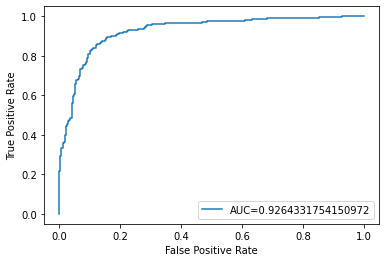

Area under the ROC cuve : 0.926433
Optimal cutoff point is : 0.360323


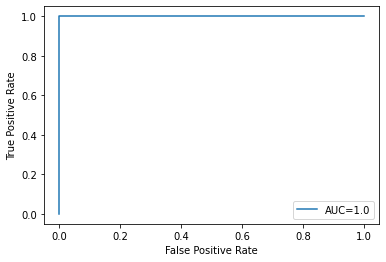

Area under the ROC cuve : 1.000000
Optimal cutoff point is : 0.357143


In [47]:
ROCanalysis(pat_pred_test, pat_true_test)
ROCanalysis(img_pred_rate_test, img_true_test)